## Wide & Deep Recommendation for large scale data - Online Serving with gPRC

This notebook demonstrates the online serving pipeline for Wide & Deep Learning on the Twitter Recsys Challenge 2021 dataset to recommend users with the tweets (items) that they might be interested in.

Online serving happens real-time whenever a user request comes. Recall service will use the pre-built [Faiss](https://github.com/facebookresearch/faiss) index to efficiently generate candidates (usually ~100 to 1000 items) from millions of items based on embedding similarity. Ranking service will further re-rank the candidates using the trained deep learning model based on user and item features for the final recommendation results (usually Top10 items).

<div>
    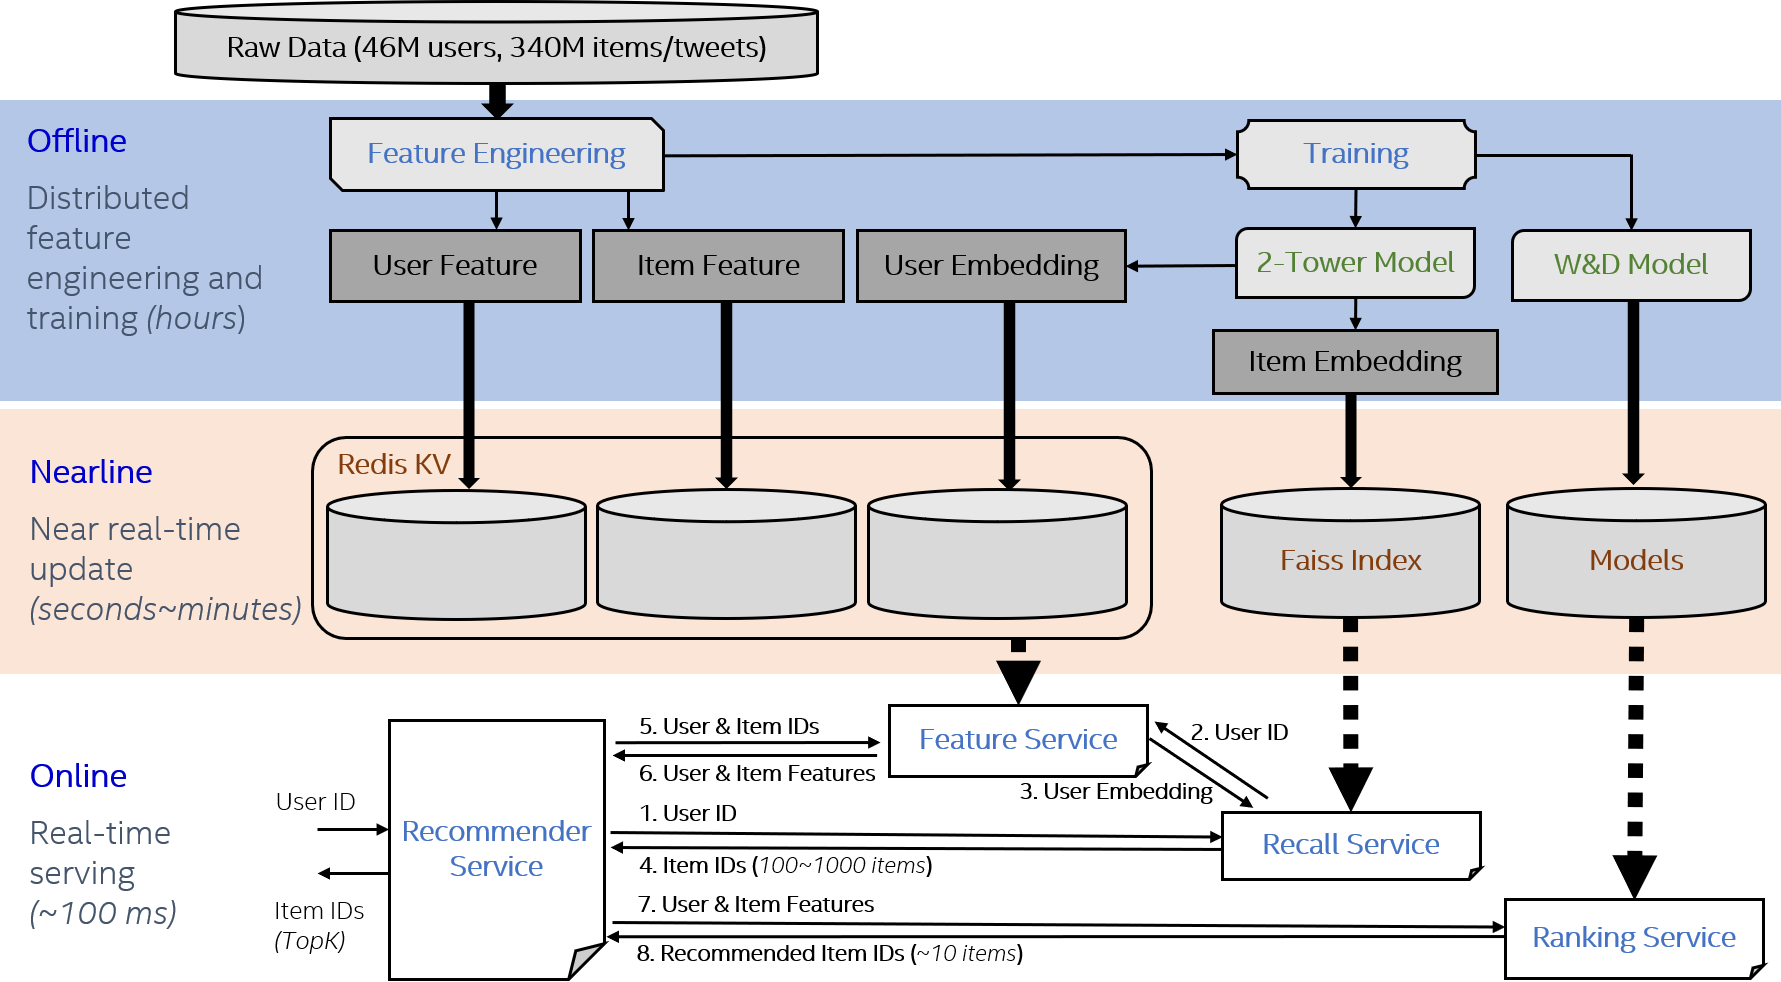
</div>

You can check the five services for online serving in the Sequence Diagram below. These 5 services can be deployed on the same server, or on various servers. Also, you can use [envoy](https://github.com/envoyproxy/envoy), [NGINX](https://www.nginx.com/), and other proxies to scale services on multiple servers.

Now let's start the recommendation process:
1. User creates a request (including multiple user ids) and call the recommender service.
2. For every user id in the user id list, the Recommender Service executes the following steps.
    1. The Recommender Service calls the Recall Service to get item candidates.
        1. The Recall Service calls the Feature Service to get the user embedding vector inferenced by the user embedding model.
        2. The Recall Service searches item candidates in the pre-built Faiss index and returns candidate item id list.
    2. The Recommender Service calls the Feature Service to get W&D model's features of the searched user.
    3. The Recommender Service calls the Feature Service to get W&D model's features of each candidate item.
    4. The Recommender Service preprocesses the user features and item features and generates the input for W&D model.
    5. The Recommender Service calls the Ranking Service and get the W&D inference results.
    6. The Recommender Service sorts the results and picks the top recommendNum items.
3. The Recommender Service returns all user's recommend results.

<div>
    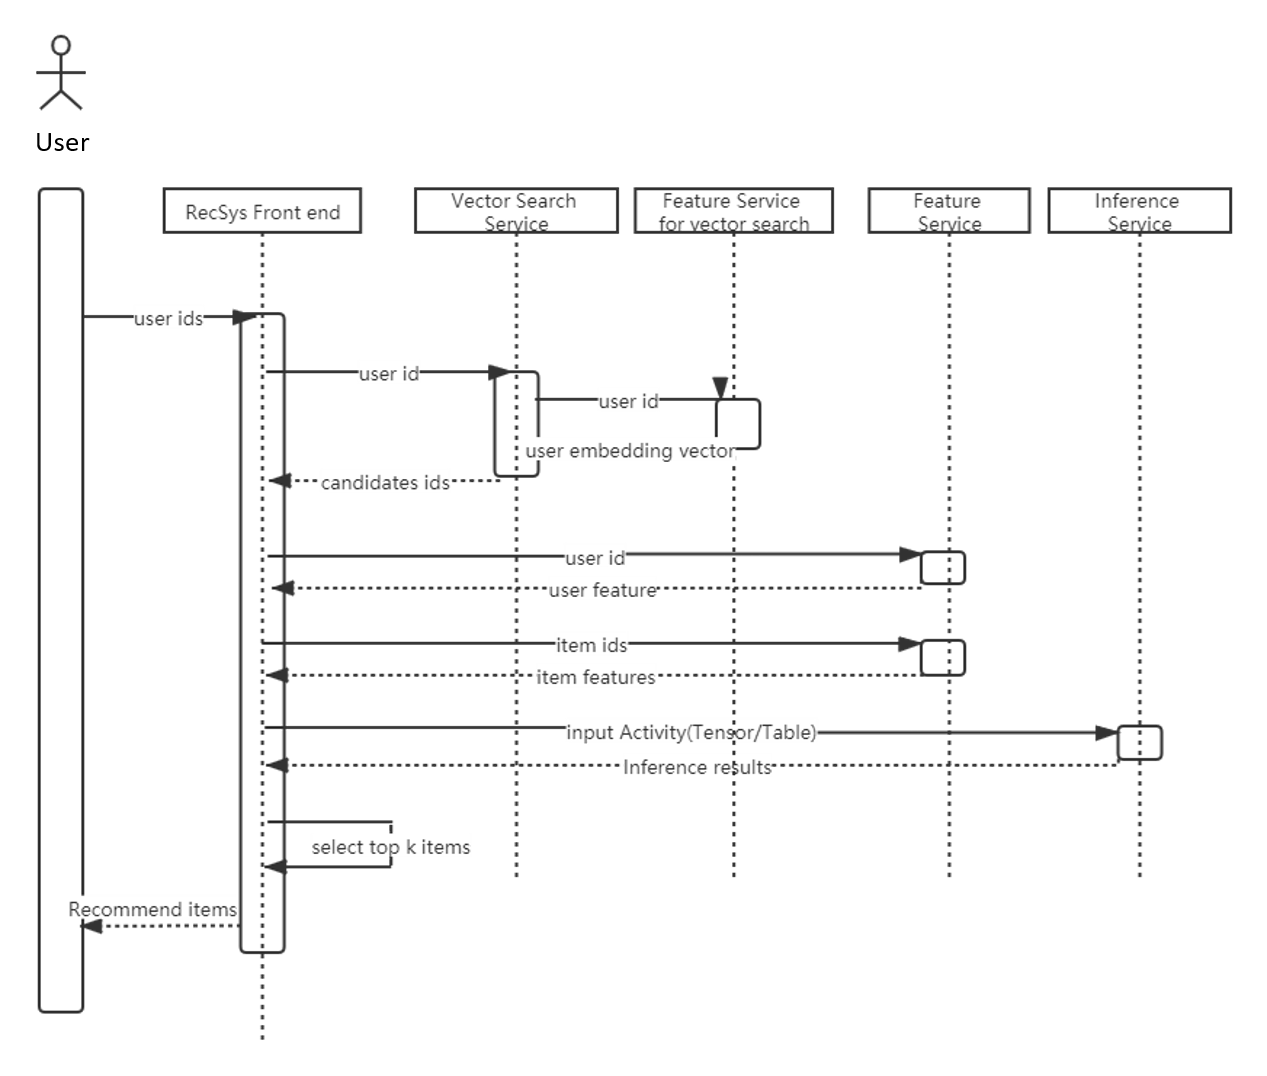
</div>

### Server Setup and Activation
Follow the instructions [here](https://github.com/intel-analytics/analytics-zoo/tree/bigdl-2.0/scala/friesian.serving) to start the services described above in the docker container.

### Run Python Client

For simpler and better demonstration purpose, we use the Python client in this notebook. You may find the instructions to run Java client at the very end of this notebook.

First of all, we import the necessary packages. Note that you need to install pyarrow and fastparquet to successfully load parquet using pandas.

In [1]:
import grpc
import recommender_pb2
import recommender_pb2_grpc

import time
import threading
import pandas as pd

Try to unset the http_proxy and https_proxy if you can not set up the connection. See this [issue](https://github.com/grpc/grpc/issues/23340) for more details.

In [2]:
import os
if 'http_proxy' in os.environ:
    del os.environ['http_proxy']
if 'https_proxy' in os.environ:
    del os.environ['https_proxy']

# To verify the envs are deleted, you should see no outputs for the following commands:
# ! echo $http_proxy
# ! echo $https_proxy

Define the utilities function to load user ids and test performance.

In [3]:
# This is a function which loads user id list.
def load_user_data(data_dir, num):
    df = pd.read_parquet(data_dir)
    user_list = df["enaging_user_id"].unique()[0: num]
    return user_list

In [4]:
# This is a customized class for test performance timing.
class Timer:
    def __init__(self):
        self.count = 0
        self.total = 0

    def reset(self):
        self.count = 0
        self.total = 0

    def add(self, time_elapse):
        self.total += time_elapse * 1000
        self.count += 1

    def get_stat(self):
        return self.count, self.total / self.count

In [5]:
import json
from IPython.display import display

# This is a function which gets backend timer metircs from the server.
def get_server_metrics(stub):
    try:
        msg = stub.getMetrics(recommender_pb2.ServerMessage())
        metrics = json.loads(msg.str)
        metrics = list(map(lambda m: [m['name'], m['_75thPercentile'], m['_95thPercentile'], m['_99thPercentile']], metrics))
        df = pd.DataFrame(metrics, columns=['name', '75thPercentile(ms)', '95thPercentile(ms)', '99thPercentile(ms)'])
        sorter = ["recommend.recall", "recommend.feature.user", "recommend.feature.item", "recommend.preprocess", "recommend.rankingInference", "recommend.topK", "recommend.overall"]
        sorterIndex = dict(zip(sorter, range(len(sorter))))
        df['name_rank'] = df['name'].map(sorterIndex)
        df.sort_values(['name_rank'], ascending = [True], inplace = True)
        del df['name_rank']
        df.reset_index(drop=True, inplace=True)
        display(df)
        # print("Got metrics:", msg.str)
    except Exception as e:
        print("RPC failed: {}".format(e))

        
# This is a function which reset all the backend timers.
def reset_server_metrics(stub):
    try:
        stub.resetMetrics(recommender_pb2.ServerMessage())
    except Exception as e:
        print("RPC failed: {}".format(e))

Define the class for recommend client. Stub in the recommend client can call the `getRecommendIDs` api of the recommend service defined in [recommender.proto](https://github.com/intel-analytics/analytics-zoo/blob/bigdl-2.0/scala/friesian.serving/src/main/proto/recommender.proto), which returns the list of items to be recommended together with the corresponding probabilities that the user is interested in each item.

In [6]:
# Build the Python recommend client.
class RecommendClient:
    def __init__(self, stub):
        self.stub = stub

    def get_user_recommends(self, user_id_list, candidate_num, recommend_num):
        try:
            results = self.stub.getRecommendIDs(
                recommender_pb2.RecommendRequest(recommendNum=recommend_num, candidateNum=candidate_num, ID=user_id_list))
            return results
        except Exception as e:
            print("RPC failed: {}".format(e))

Define the client thread to monitor the multi-client case. Create a RecommendClient in each thread and invoke the recommender service. The recommendation output and performance results would be printed after all the user requests have been handled.

In [7]:
# Build the client thread to monitor the multi-client case.
def single_thread_client(stub, user_list, timer, candidate_num, recommend_num, show):
    client = RecommendClient(stub)
    result_dict = dict()
    start = time.perf_counter()
    for user_id in user_list:
        search_start = time.perf_counter()
        results = client.get_user_recommends([user_id], candidate_num, recommend_num)
        result_dict[user_id] = results
        search_end = time.perf_counter()
        timer.add(search_end - search_start)
    time_elapse = time.perf_counter() - start
    if show == 0:
        print("\nShow 1 result: ")
        for user_id in user_list[:1]:
            print("\tUser id: " + str(user_id))
            print("\tResult IDProbList:")
            r = result_dict[user_id].IDProbList
            print("\titem id list: ", r[0].ID)
            print("\tprob    list: ", r[0].prob, "\n")
        show = False
        
    #print(Fore.YELLOW + "Total user number:", len(user_list))
    #print(Fore.YELLOW + "Average search time:", time_elapse / len(user_list) * 1000)
    #print(Style.RESET_ALL)

Create the grpc channel and RecommenderStub. The channel and RecommenderStub would remotely invoke the gRPC service.

In [8]:
# Provide the port your server is listening on.
channel = grpc.insecure_channel('localhost:8980')
stub = recommender_pb2_grpc.RecommenderStub(channel)
client_timer = Timer()

Specify the parameters to run the demo. You can make changes to them if you wish.

- test_number: The number of performance tests to run.
- thread_number: The number of parallel threads to run the recommend service.
- user_number: The number of total users to recommend.
- candidate_number: The number of candidate items to be generated by the vector search service.
- recommend_number: The number of items to be eventually recommended to the user.

In [9]:
test_number = 2
thread_number = 4
user_number = 1500
candidate_number = 100
recommend_number = 10

Load user ids from the parquet file. There are 15000000 users in the sample dataset we prepare.

In [10]:
# specify your own data_path
print("Got user_number: " + str(user_number))
user_list = load_user_data('/home/yina/Documents/data/recsys/wnd_813/wnd_user_2000.parquet', user_number)
# If any load error exists, use the dummy users below instead to run.
# user_list = [36407] * user_number.value

Got user_number: 1500


Now everything is ready and let's start the online serving test by launching multiple client threads in parallel.

In [11]:
print("Got test_number: " + str(test_number))
print("Got thread_number: " + str(thread_number))
print("Got candidate_number: " + str(candidate_number))
print("Got recommend_number: " + str(recommend_number))
print("\n")
thread_list = []

for i in range(test_number):
    print("Test round: ", i + 1)

    for j in range(thread_number):
        thread = threading.Thread(target=single_thread_client, args=(stub, user_list, client_timer, candidate_number, recommend_number, j))
        thread_list.append(thread)
        thread.start()
        
    for thread in thread_list:
        thread.join()

    count, avg = client_timer.get_stat()
    client_timer.reset()
    get_server_metrics(stub)
    reset_server_metrics(stub)
    time.sleep(10)

Got test_number: 2
Got thread_number: 4
Got candidate_number: 100
Got recommend_number: 10


Test round:  1

Show 1 result: 
	User id: 663771
	Result IDProbList:
	item id list:  [869593, 1880835, 7440660, 3801895, 8877609, 788560, 7347216, 4412021, 7229581, 7228084]
	prob    list:  [0.8452638983726501, 0.7596899271011353, 0.7592239379882812, 0.7534275650978088, 0.7508522272109985, 0.741190493106842, 0.7232050895690918, 0.719520092010498, 0.7178489565849304, 0.7178086042404175] 



,name,75thPercentile(ms),95thPercentile(ms),99thPercentile(ms)
0,recommend.recall,5.254646,5.896600,6.544488
1,recommend.feature.user,0.605694,0.745800,0.852584
2,recommend.feature.item,8.806979,9.790104,11.361189
3,recommend.preprocess,5.020759,8.383041,9.641154
4,recommend.rankingInference,7.505015,8.700386,11.757629
5,recommend.topK,0.296787,0.375416,0.533316
6,recommend.overall,27.557323,31.134438,33.137436


Test round:  2

Show 1 result: 
	User id: 663771
	Result IDProbList:
	item id list:  [869593, 1880835, 7440660, 3801895, 8877609, 788560, 7347216, 4412021, 7229581, 7228084]
	prob    list:  [0.8452638983726501, 0.7596899271011353, 0.7592239379882812, 0.7534275650978088, 0.7508522272109985, 0.741190493106842, 0.7232050895690918, 0.719520092010498, 0.7178489565849304, 0.7178086042404175] 



,name,75thPercentile(ms),95thPercentile(ms),99thPercentile(ms)
0,recommend.recall,5.205405,5.826960,7.778952
1,recommend.feature.user,0.607082,0.741776,0.851301
2,recommend.feature.item,9.010496,9.932654,10.738153
3,recommend.preprocess,5.084482,8.360598,10.044985
4,recommend.rankingInference,7.475545,8.938040,11.589411
5,recommend.topK,0.298764,0.372073,0.540902
6,recommend.overall,27.523879,31.177965,32.830744


### Run Java Client

After generating proto java files by following the steps [here](https://github.com/intel-analytics/analytics-zoo/tree/bigdl-2.0/scala/friesian.serving#generate-proto-java-files), similarly, you can call recommend service function `getRecommendIDs` using the blocking stub.

Sample code to run the Java client is shown below. You can check the [here](https://github.com/intel-analytics/analytics-zoo/blob/bigdl-2.0/scala/friesian.serving/src/main/java/com/intel/analytics/bigdl/friesian/serving/recommender/RecommenderClient.java) for the complete example.

```java
import com.intel.analytics.bigdl.friesian.serving.grpc.generated.recommender.RecommenderGrpc;
import com.intel.analytics.bigdl.friesian.serving.grpc.generated.recommender.RecommenderProto.*;
import io.grpc.Channel;
import io.grpc.ManagedChannel;
import org.apache.log4j.Logger;

public class RecommendClient {
    private static final Logger logger = Logger.getLogger(RecommenderClient.class.getName());
    
    public static void main(String[] args) {
        // Init a channel
        ManagedChannel channel = ManagedChannelBuilder.forTarget(target).usePlaintext().build();
        // Init a recommend service blocking stub
        RecommenderGrpc.RecommenderBlockingStub blockingStub = RecommenderGrpc.newBlockingStub(channel);
        // Construct a request
        int[] userIds = new int[]{36407};
        int candidateNum = 50;
        int recommendNum = 10;
        RecommendRequest.Builder request = RecommendRequest.newBuilder();
        for (int id: userIds) {
            request.addID(id);
        }
        request.setCandidateNum(candidateNum);
        request.setRecommendNum(recommendNum);
        RecommendIDProbs recommendIDProbs = null;
        try {
            recommendIDProbs = blockingStub.getRecommendIDs(request.build());
            logger.info(recommendIDProbs.getIDProbListList());
        } catch (StatusRuntimeException e) {
            logger.warn("RPC failed: " + e.getStatus().toString());
        }
    }
}
```